In [1]:
! pip install pandas torch torchvision pillow numpy


In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import torch.optim as optim

import numpy as np


In [3]:
import random

# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random Seed for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("Random seed set to 42")

Using device: cuda:0
Random seed set to 42


In [4]:
import kagglehub

path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


### Split the data into train val, and test set (starified)

In [5]:
import os

os.listdir("/kaggle/input/horse-breeds")


['01_103.png',
 '03_068.png',
 '02_060.png',
 '03_030.png',
 '07_065.png',
 '07_020.png',
 '06_042.png',
 '02_069.png',
 '06_016.png',
 '01_042.png',
 '02_032.png',
 '07_002.png',
 '02_057.png',
 '01_018.png',
 '06_098.png',
 '06_041.png',
 '07_115.png',
 '03_032.png',
 '06_072.png',
 '03_014.png',
 '01_097.png',
 '01_049.png',
 '02_004.png',
 '05_041.png',
 '02_002.png',
 '07_054.png',
 '03_100.png',
 '07_026.png',
 '02_084.png',
 '07_060.png',
 '03_071.png',
 '04_002.png',
 '01_027.png',
 '05_014.png',
 '02_011.png',
 '01_107.png',
 '06_004.png',
 '03_034.png',
 '02_021.png',
 '07_086.png',
 '01_056.png',
 '03_050.png',
 '03_004.png',
 '04_010.png',
 '06_054.png',
 '03_029.png',
 '06_040.png',
 '06_110.png',
 '03_055.png',
 '06_119.png',
 '02_039.png',
 '07_016.png',
 '01_040.png',
 '02_019.png',
 '06_035.png',
 '05_005.png',
 '03_088.png',
 '03_061.png',
 '06_086.png',
 '05_009.png',
 '07_046.png',
 '04_007.png',
 '07_039.png',
 '01_060.png',
 '01_086.png',
 '06_078.png',
 '05_033.p

In [16]:
path = "/kaggle/input/horse-breeds"
files = os.listdir(path)

data = []

for f in files:
    label = f.split("_")[0]   # 01, 02, 03 ...
    data.append([f, label])

df = pd.DataFrame(data, columns=["image_name", "label"])

In [17]:
num_classes = df['label'].nunique()
print("Number of classes:", num_classes)

class_names = df['label'].unique()
print("Class names:")
print(class_names)


Number of classes: 7
Class names:
['01' '03' '02' '07' '06' '05' '04']


In [41]:
class_names = [
    "Akhal-Teke",          # 0 → 01
    "Appaloosa",           # 1 → 02
    "Orlov Trotter",       # 2 → 03
    "Vladimir Heavy Draft",# 3 → 04
    "Percheron",           # 4 → 05
    "Arabian",             # 5 → 06
    "Friesian"             # 6 → 07
]


In [43]:
for images, labels in val_loader:
    print(labels[:5])
    break


tensor([0, 1, 0, 0, 3])


In [44]:
print(class_names[0])  # Akhal-Teke
print(class_names[6])  # Friesian


Akhal-Teke
Friesian


In [45]:
from collections import Counter

class_counts = Counter(df['label'])

print("Class Balance:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} images")


Class Balance:
Class 01: 123 images
Class 03: 107 images
Class 02: 105 images
Class 07: 120 images
Class 06: 122 images
Class 05: 56 images
Class 04: 37 images


In [46]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)

print("train len:", len(train_df))
print("val len:", len(val_df))
print("test len:", len(test_df))


train len: 469
val len: 100
test len: 101


### Dataset Class

In [47]:
from torch.utils.data import Dataset
from PIL import Image
import os

class HorseDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {f"{i:02}": i-1 for i in range(1, 8)}  # '01'->0, '02'->1, ... '07'->6

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        label = self.label_map[row["label"]]
        if self.transform:
            image = self.transform(image)
        return image, label


### Transforms

In [48]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])



### Create Dataloader objects

In [49]:
import torch
from torch.utils.data import WeightedRandomSampler, DataLoader

class_counts = train_df['label'].value_counts().to_dict()
num_samples = len(train_df)
weights = train_df['label'].map(lambda x: num_samples / class_counts[x]).values
weights = torch.DoubleTensor(weights)

train_sampler = WeightedRandomSampler(weights, num_samples=num_samples, replacement=True)


In [50]:
from torch.utils.data import DataLoader, WeightedRandomSampler


train_dataset = HorseDataset(train_df, path, transform=transform)
val_dataset   = HorseDataset(val_df, path, transform=transform)
test_dataset  = HorseDataset(test_df, path, transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=train_sampler,  
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)


#### Display some images

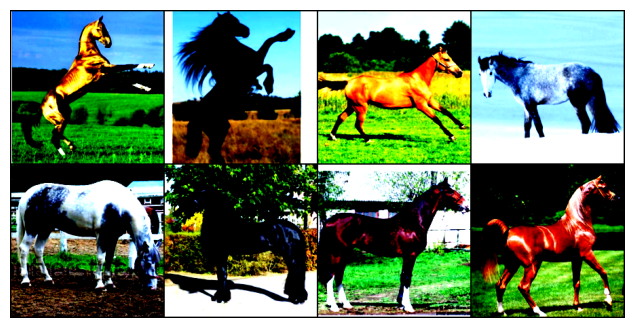

In [51]:
import torchvision
import matplotlib.pyplot as plt


images, labels = next(iter(train_loader))

grid = torchvision.utils.make_grid(images[:8], nrow=4)

plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

### Define Model 


In [52]:
import torch.nn as nn

class HorseCNN(nn.Module):
    def __init__(self):
        super(HorseCNN, self).__init__()
        
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1=nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2=nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3=nn.BatchNorm2d(64)



        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 7) 

    def forward(self, x):
         # Conv 1
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        
        # Conv 2
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        
        # Conv 3
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        
        # Flatten
        x = x.view(x.size(0), -1) 
        
        # Dense Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [53]:
model = HorseCNN().to(device)



### define Loss and Optimizer

In [54]:
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Build epoch_training and validate function loop 

In [55]:
def training_loop(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
    """
    Trains and validates a PyTorch neural network model.

    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        loss_function: The loss function to use for training.
        optimizer: The optimization algorithm.
        num_epochs: The total number of epochs to train for.
        device: The device (e.g., 'cpu' or 'cuda') to run the training on.

    Returns:
        A tuple containing:
        - The trained model.
        - A list of metrics [train_losses, val_losses, val_accuracies].
    """
    # Move the model to the specified device (CPU or GPU)
    model.to(device)
    
    # Initialize lists to store training and validation metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Print a message indicating the start of the training process
    print("--- Training Started ---")
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Initialize running loss for the current epoch
        running_loss = 0.0
        # Iterate over batches of data in the training loader
        for images, labels in train_loader:
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)
            
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Perform a forward pass to get model outputs
            outputs = model(images)
            # Calculate the loss
            loss = loss_function(outputs, labels)
            # Perform a backward pass to compute gradients
            loss.backward()
            # Update the model parameters
            optimizer.step()
            
            # Accumulate the training loss for the batch
            running_loss += loss.item() * images.size(0)
            
        # Calculate the average training loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        # Append the epoch loss to the list of training losses
        train_losses.append(epoch_loss)
        
        # Set the model to evaluation mode
        model.eval()
        # Initialize running validation loss and correct predictions count
        running_val_loss = 0.0
        correct = 0
        total = 0
        # Disable gradient calculations for validation
        with torch.no_grad():
            # Iterate over batches of data in the validation loader
            for images, labels in val_loader:
                # Move images and labels to the specified device
                images, labels = images.to(device), labels.to(device)
                
                # Perform a forward pass to get model outputs
                outputs = model(images)
                
                # Calculate the validation loss for the batch
                val_loss = loss_function(outputs, labels)
                # Accumulate the validation loss
                running_val_loss += val_loss.item() * images.size(0)
                
                # Get the predicted class labels
                _, predicted = torch.max(outputs, 1)
                # Update the total number of samples
                total += labels.size(0)
                # Update the number of correct predictions
                correct += (predicted == labels).sum().item()
                
        # Calculate the average validation loss for the epoch
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        # Append the epoch validation loss to the list
        val_losses.append(epoch_val_loss)
        
        # Calculate the validation accuracy for the epoch
        epoch_accuracy = 100.0 * correct / total
        # Append the epoch accuracy to the list
        val_accuracies.append(epoch_accuracy)
        
        # Print the metrics for the current epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy:.2f}%")
        
    # Print a message indicating the end of the training process
    print("--- Finished Training ---")
    
    # Consolidate all metrics into a single list
    metrics = [train_losses, val_losses, val_accuracies]
    
    # Return the trained model and the collected metrics
    return model, metrics

In [57]:
trained_model, training_metrics = training_loop(
    model=model,             
    train_loader=train_loader, 
    val_loader=val_loader, 
    loss_function=loss_function, 
    optimizer=optimizer,       
    num_epochs=15, 
    device=device
)



--- Training Started ---
Epoch [1/15], Train Loss: 0.1271, Val Loss: 2.7453, Val Accuracy: 49.00%
Epoch [2/15], Train Loss: 0.0960, Val Loss: 2.7805, Val Accuracy: 48.00%
Epoch [3/15], Train Loss: 0.0560, Val Loss: 2.3530, Val Accuracy: 57.00%
Epoch [4/15], Train Loss: 0.2730, Val Loss: 2.5924, Val Accuracy: 54.00%
Epoch [5/15], Train Loss: 0.1271, Val Loss: 2.4531, Val Accuracy: 57.00%
Epoch [6/15], Train Loss: 0.0474, Val Loss: 2.6945, Val Accuracy: 57.00%
Epoch [7/15], Train Loss: 0.0754, Val Loss: 3.5889, Val Accuracy: 52.00%
Epoch [8/15], Train Loss: 0.1463, Val Loss: 3.2835, Val Accuracy: 54.00%
Epoch [9/15], Train Loss: 0.0323, Val Loss: 3.6052, Val Accuracy: 52.00%
Epoch [10/15], Train Loss: 0.0645, Val Loss: 3.8191, Val Accuracy: 47.00%
Epoch [11/15], Train Loss: 0.0194, Val Loss: 3.0687, Val Accuracy: 61.00%
Epoch [12/15], Train Loss: 0.0234, Val Loss: 2.9248, Val Accuracy: 59.00%
Epoch [13/15], Train Loss: 0.0191, Val Loss: 3.7222, Val Accuracy: 55.00%
Epoch [14/15], Train L


--- Training Plots ---



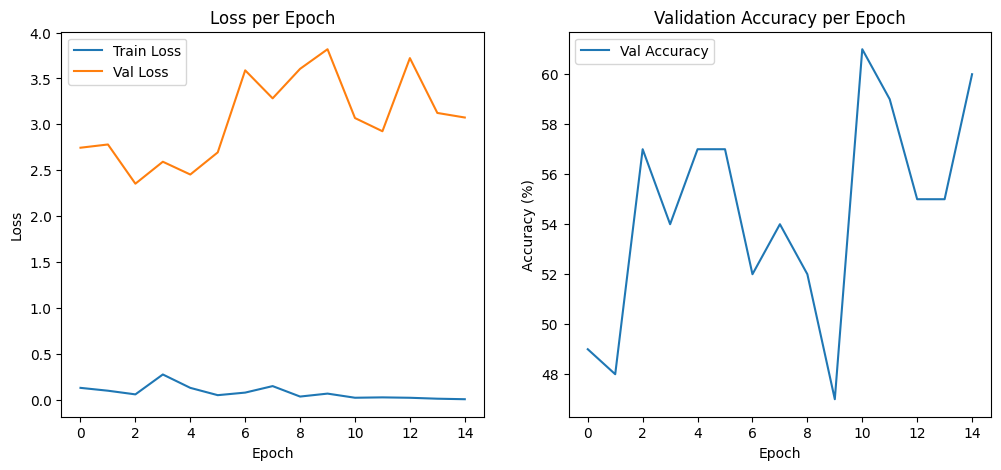

In [58]:
import matplotlib.pyplot as plt
print("\n--- Training Plots ---\n")

train_losses, val_losses, val_accuracies = training_metrics

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy per Epoch")
plt.legend()

plt.show()


In [59]:
import matplotlib.pyplot as plt
import torch

def visualise_predictions(model, data_loader, class_names, device, grid=(3, 3)):
    model.eval()
    images_shown = 0
    rows, cols = grid

    plt.figure(figsize=(cols * 4, rows * 4))

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                images_shown += 1
                if images_shown > rows * cols:
                    plt.show()
                    return

                plt.subplot(rows, cols, images_shown)

                img = images[i].cpu().permute(1, 2, 0)
                img = img.clamp(0, 1)

                plt.imshow(img)
                plt.axis("off")

                title_color = "green" if preds[i] == labels[i] else "red"
                plt.title(
                    f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}",
                    color=title_color
                )

    plt.show()


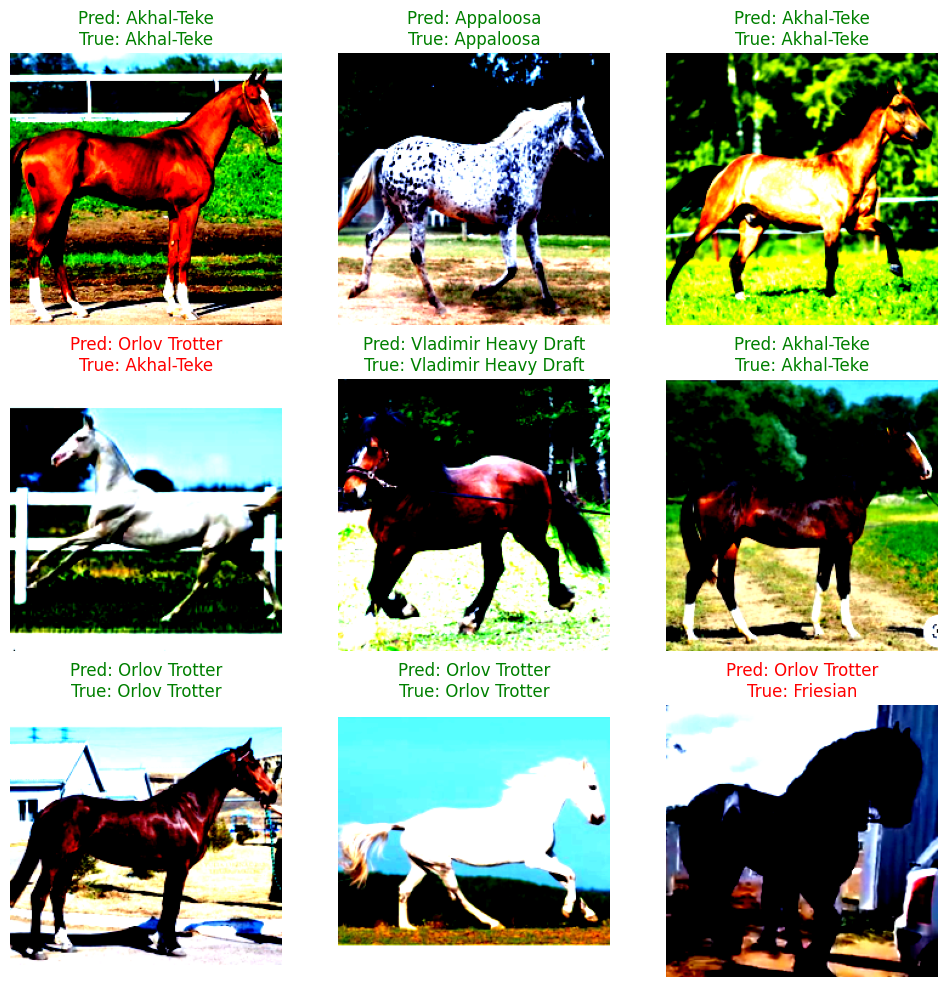

In [60]:
visualise_predictions(
    model=trained_model,
    data_loader=val_loader,
    class_names=class_names,
    device=device,
    grid=(3, 3)
)


### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

As the number of epochs increases, the training loss gradually decreases, but the validation loss increases, while the accuracy gradually increases. This indicates that the model is starting to overfit: it is learning the training data well, but its performance on unseen validation data is worsening.

## Transfer Learning

In [61]:
from torchvision import models

model_ft = models.resnet18(weights='DEFAULT')
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [62]:
import torch.nn as nn

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)  


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [65]:
trained_model, training_metrics = training_loop(
    model=model_ft,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=criterion,
    optimizer=optimizer_ft,
    num_epochs=15,
    device=device
)



--- Training Started ---
Epoch [1/15], Train Loss: 0.8070, Val Loss: 0.7964, Val Accuracy: 70.00%
Epoch [2/15], Train Loss: 0.7787, Val Loss: 0.6570, Val Accuracy: 79.00%
Epoch [3/15], Train Loss: 0.6498, Val Loss: 0.6152, Val Accuracy: 83.00%
Epoch [4/15], Train Loss: 0.5947, Val Loss: 0.6770, Val Accuracy: 77.00%
Epoch [5/15], Train Loss: 0.5424, Val Loss: 0.6036, Val Accuracy: 82.00%
Epoch [6/15], Train Loss: 0.5160, Val Loss: 0.5503, Val Accuracy: 84.00%
Epoch [7/15], Train Loss: 0.4456, Val Loss: 0.5742, Val Accuracy: 83.00%
Epoch [8/15], Train Loss: 0.4344, Val Loss: 0.5178, Val Accuracy: 87.00%
Epoch [9/15], Train Loss: 0.3855, Val Loss: 0.5546, Val Accuracy: 82.00%
Epoch [10/15], Train Loss: 0.3921, Val Loss: 0.5172, Val Accuracy: 85.00%
Epoch [11/15], Train Loss: 0.3715, Val Loss: 0.4943, Val Accuracy: 88.00%
Epoch [12/15], Train Loss: 0.4067, Val Loss: 0.4682, Val Accuracy: 87.00%
Epoch [13/15], Train Loss: 0.3670, Val Loss: 0.5021, Val Accuracy: 84.00%
Epoch [14/15], Train L

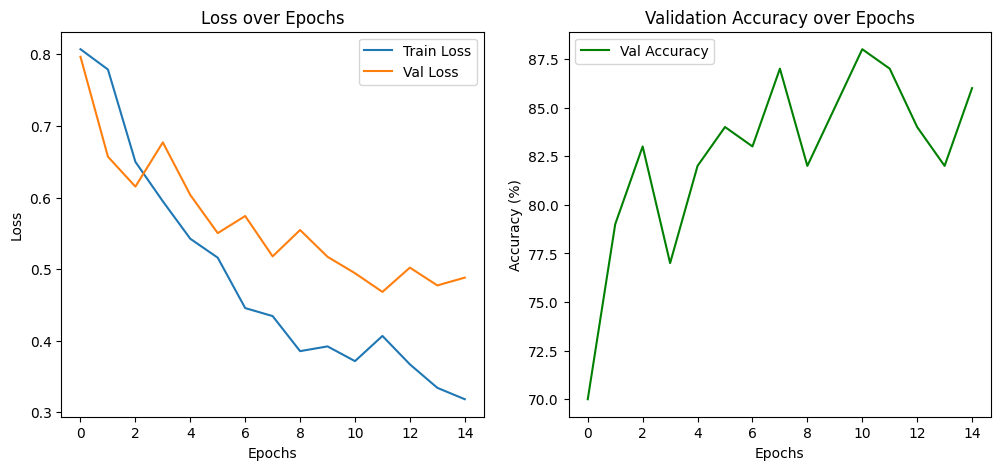

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Train & Val Loss
plt.subplot(1,2,1)
plt.plot(training_metrics[0], label='Train Loss')
plt.plot(training_metrics[1], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Validation Accuracy
plt.subplot(1,2,2)
plt.plot(training_metrics[2], label='Val Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.show()


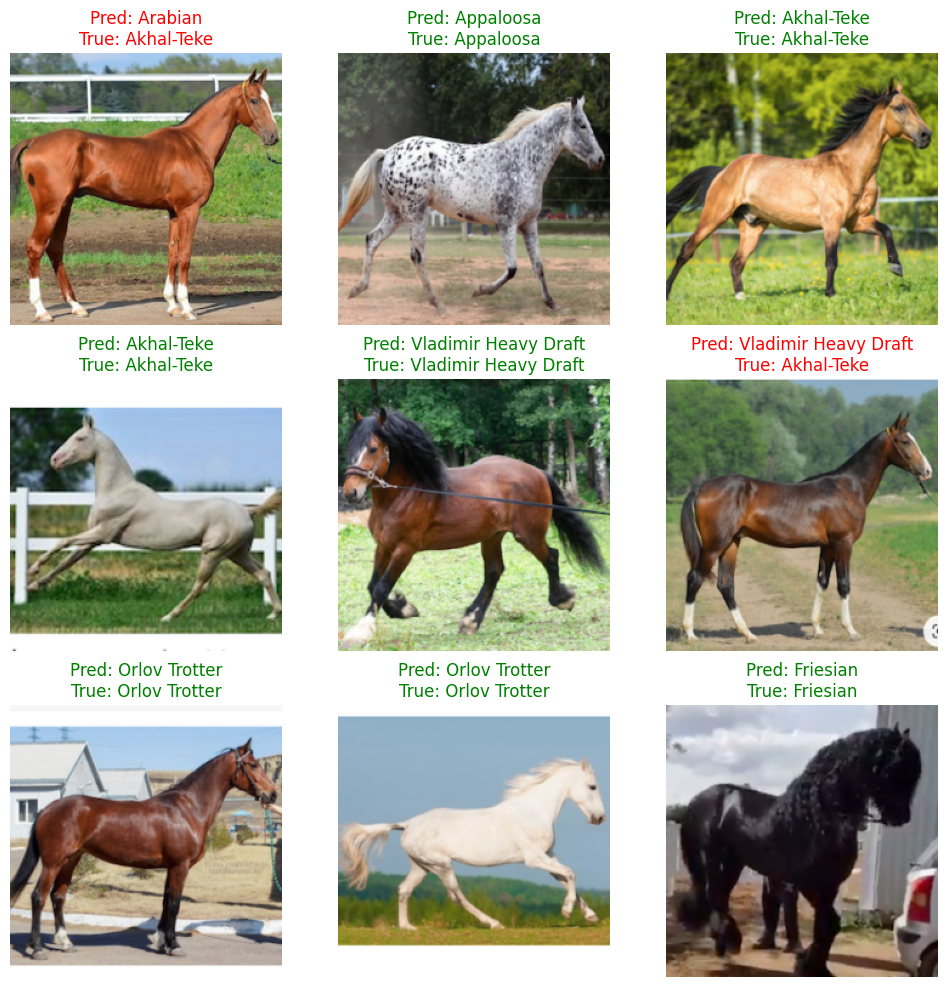

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_model(model, val_loader, class_names, device, num_images=9):
    model.eval()
    images_shown = 0
    rows, cols = 3, 3   

    plt.figure(figsize=(cols*4, rows*4))

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(images)):
                images_shown += 1

                if images_shown > num_images:
                    plt.show()
                    return

                plt.subplot(rows, cols, images_shown)
                plt.axis("off")

                img = images[i].cpu().permute(1,2,0)
                img = img * torch.tensor([0.229,0.224,0.225]) + torch.tensor([0.485,0.456,0.406])
                img = img.clamp(0,1)
                plt.imshow(img)

                pred_name = class_names[preds[i].item()]
                true_name = class_names[labels[i].item()]
                color = "green" if preds[i] == labels[i] else "red"
                plt.title(f"Pred: {pred_name}\nTrue: {true_name}", color=color)

    plt.show()

visualize_model(model_ft, val_loader, class_names, device, num_images=9)


### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

As the number of epochs increases, both the training loss and validation loss gradually decrease, while the accuracy gradually increases. This indicates that the model is learning effectively and its performance improves over time.

If the validation loss starts increasing while the training loss continues to decrease, the model might be overfitting.

If both training and validation losses remain high and accuracy is low, the model might be underfitting.

In our case, since the validation loss is decreasing along with the training loss and the accuracy is improving, the model is neither overfitting nor underfitting significantly and is learning well.